In [1]:
import psycopg2
from io import StringIO
import pandas as pd
import os
import traceback
from sqlalchemy import create_engine, MetaData
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, RepeatedKFold, GroupKFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score,accuracy_score, roc_auc_score
from imblearn.over_sampling import RandomOverSampler
from lightgbm import LGBMClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [0]:
pd.set_option('display.max_columns', None)

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
!ls -l /content/gdrive/'My Drive'/'SATURDAYS AI GR3 CLINICA'

total 1424063
-rw------- 1 root root     910527 Jul  6 08:56  analisis.ipynb
-rw------- 1 root root       7675 Jul  2 19:40  Analysis2.ipynb
-rw------- 1 root root        151 Jul  5 19:47 'Copy of PRESENTACION REV1.gslides'
-rw------- 1 root root    2278545 Jul  6 10:21 'Copy of PRESENTACION REV2.pptx'
-rw------- 1 root root        151 Jun 29 07:51  DatasetSimu.gsheet
-rw------- 1 root root 1424247118 Jun 29 10:03  datos.csv
-rw------- 1 root root        151 Jul  3 12:47 'Datos hospital.gsheet'
-rw------- 1 root root     750970 Jul  3 10:44  datos_small.csv
-rw------- 1 root root        151 Jul  6 10:35 'David Viejo parte.gslides'
-rw------- 1 root root        151 Jun 22 08:19 'Deimos v1_1 Manual usuario (1).gdoc'
-rw------- 1 root root   12834773 Jun 22 08:12 'Deimos v1_1 Manual usuario (1).pdf'
-rw------- 1 root root        151 Jun 22 09:12 'Deimos v1_1 Manual usuario.gdoc'
-rw------- 1 root root   12834773 Jun 22 08:12 'Deimos v1_1 Manual usuario.pdf'
-rw------- 1 root root    18334

In [0]:
data_file = "/content/gdrive/My Drive/SATURDAYS AI GR3 CLINICA/datos.csv"
limit = 50000
# df = pd.read_csv(data_file,nrows=limit)
df = pd.read_csv(data_file)

In [0]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [7]:
df.head()

,dep_name,esi,age,gender,ethnicity,race,lang,religion,maritalstatus,employstatus,insurance_status,disposition,arrivalmode,arrivalmonth,arrivalday,arrivalhour_bin,previousdispo,2ndarymalig,abdomhernia,abdomnlpain,abortcompl,acqfootdef,acrenlfail,acutecvd,acutemi,acutphanm,adjustmentdisorders,adltrespfl,alcoholrelateddisorders,allergy,amniosdx,analrectal,anemia,aneurysm,anxietydisorders,appendicitis,artembolism,asppneumon,asthma,attentiondeficitconductdisruptivebeha,backproblem,biliarydx,birthasphyx,birthtrauma,bladdercncr,blindness,bnignutneo,bonectcncr,bph,brainnscan,breastcancr,breastdx,brnchlngca,bronchitis,burns,cardiaarrst,cardiacanom,carditis,cataract,cervixcancr,chestpain,chfnonhp,chrkidneydisease,coaghemrdx,coloncancer,comabrndmg,complicdevi,complicproc,conduction,contraceptiv,copd,coronathero,crushinjury,cysticfibro,deliriumdementiaamnesticothercognitiv,developmentaldisorders,diabmelnoc,diabmelwcm,disordersusuallydiagnosedininfancych,diverticulos,dizziness,dminpreg,dysrhythmia,earlylabor,ecodesadverseeffectsofmedicalcare,ecodesadverseeffectsofmedicaldrugs,ecodescutpierce,ecodesdrowningsubmersion,ecodesfall,ecodesfirearm,ecodesfireburn,ecodesmachinery,ecodesmotorvehicletrafficmvt,ecodesnaturalenvironment,ecodesotherspecifiedandclassifiable,ecodesotherspecifiednec,ecodespedalcyclistnotmvt,ecodesplaceofoccurrence,ecodespoisoning,ecodesstruckbyagainst,ecodessuffocation,ecodestransportnotmvt,ecodesunspecified,ectopicpreg,encephalitis,endometrios,epilepsycnv,esophcancer,esophgealdx,exameval,eyeinfectn,fatigue,femgenitca,feminfertil,fetaldistrs,fluidelcdx,fuo,fxarm,fxhip,fxleg,fxskullfac,gangrene,gasduoulcer,gastritis,gastroent,giconganom,gihemorrhag,giperitcan,glaucoma,goutotcrys,guconganom,hdnckcancr,headachemig,hemmorhoids,hemorrpreg,hepatitis,hivinfectn,hodgkinsds,hrtvalvedx,htn,htncomplicn,htninpreg,hyperlipidem,immunitydx,immunizscrn,impulsecontroldisordersnec,inducabortn,infectarth,influenza,infmalegen,intestinfct,intobstruct,intracrninj,jointinjury,kidnyrnlca,lateeffcvd,leukemias,liveborn,liveribdca,longpregncy,lowbirthwt,lungexternl,lymphenlarg,maintchemr,malgenitca,maligneopls,malposition,meningitis,menopausldx,menstrualdx,miscellaneousmentalhealthdisorders,mooddisorders,mouthdx,ms,multmyeloma,mycoses,nauseavomit,neoplsmunsp,nephritis,nervcongan,nonepithca,nonhodglym,nutritdefic,obrelatedperintrauma,opnwndextr,opnwndhead,osteoarthros,osteoporosis,otacqdefor,otaftercare,otbnignneo,otbonedx,otcirculdx,otcomplbir,otconganom,otconntiss,otdxbladdr,otdxkidney,otdxstomch,otendodsor,otfemalgen,othbactinf,othcnsinfx,othematldx,othercvd,othereardx,otheredcns,othereyedx,othergidx,othergudx,otherinjury,otherpregnancyanddeliveryincludingnormal,otherscreen,othfracture,othheartdx,othinfectns,othliverdx,othlowresp,othmalegen,othnervdx,othskindx,othveindx,otinflskin,otitismedia,otjointdx,otnutritdx,otperintdx,otpregcomp,otprimryca,otrespirca,otupprresp,otuprspin,ovariancyst,ovarycancer,pancreascan,pancreasdx,paralysis,parkinsons,pathologfx,pelvicobstr,perintjaund,peripathero,peritonitis,personalitydisorders,phlebitis,pid,pleurisy,pneumonia,poisnnonmed,poisnotmed,poisonpsych,precereoccl,prevcsectn,prolapse,prostatecan,pulmhartdx,rctmanusca,rehab,respdistres,retinaldx,rheumarth,schizophreniaandotherpsychoticdisorde,screeningandhistoryofmentalhealthan,septicemia,septicemiaexceptinlabor,sexualinfxs,shock,sicklecell,skininfectn,skinmelanom,sle,socialadmin,spincorinj,spontabortn,sprain,stomchcancr,substancerelateddisorders,suicideandintentionalselfinflictedin,superficinj,syncope,teethdx,testiscancr,thyroidcncr,thyroiddsor,tia,tonsillitis,tuberculosis,ulceratcol,ulcerskin,umbilcord,unclassified,urinstone,urinyorgca,uteruscancr,uti,varicosevn,viralinfect,whtblooddx,n_edvisits,n_admissions,absolutelymphocytecount_last,acetonebld_last,alanineaminotransferase(alt)_last,albumin_last,alkphos_last,anc(absneutrophilcount)_last,aniongap_last,aspartateaminotransferase(ast)_last,"b-typenatriureticpeptide,pro(probnp)_last",baseexcess(poc)_last,"baseex

In [8]:
df[["disposition", "age", "gender", "arrivalday", "allergy","n_surgeries" ]].head(10)

,disposition,age,gender,arrivalday,allergy,n_surgeries
0,Discharge,40.0,Male,Tuesday,0,1
1,Discharge,66.0,Male,Tuesday,0,2
2,Discharge,66.0,Male,Thursday,0,2
3,Discharge,66.0,Male,Saturday,0,2
4,Admit,84.0,Female,Tuesday,0,5
5,Discharge,86.0,Female,Monday,0,10
6,Admit,86.0,Female,Wednesday,0,10
7,Discharge,87.0,Female,Saturday,0,11
8,Admit,75.0,Male,Sunday,0,4
9,Admit,75.0,Male,Sunday,0,4


In [0]:
# Categorical boolean mask
categorical_feature_mask = df.dtypes==object
# filter categorical columns using mask and turn it into a list
categorical_cols = df.columns[categorical_feature_mask].tolist()
categorical_cols = [col for col in categorical_cols if col != 'disposition']

In [0]:
float_feature_mask = df.dtypes==np.float64
int64_feature_mask = df.dtypes==np.int64
int32_feature_mask = df.dtypes==np.int32
uint8_feature_mask = df.dtypes==np.uint8
numeric_cols = df.columns[uint8_feature_mask].tolist() + df.columns[float_feature_mask].tolist() + df.columns[int64_feature_mask].tolist() + df.columns[int32_feature_mask].tolist()

In [11]:
len(numeric_cols) + len(categorical_cols) - len(df.columns)

-1

In [12]:
categorical_cols

['dep_name',
 'gender',
 'ethnicity',
 'race',
 'lang',
 'religion',
 'maritalstatus',
 'employstatus',
 'insurance_status',
 'arrivalmode',
 'arrivalmonth',
 'arrivalday',
 'arrivalhour_bin',
 'previousdispo']

In [13]:
df["disposition"].unique()

array(['Discharge', 'Admit'], dtype=object)

In [14]:
df["esi"].unique()

array([ 4.,  2.,  3.,  1.,  5., nan])

In [0]:
df["disposition"] =  df["disposition"].apply(lambda x: 1 if x  == 'Admit' else 0)

In [0]:
# ONE HOT ENCODING de categoricos
df = pd.get_dummies(df, columns=categorical_cols)

In [0]:
len(df.columns)

1057

In [0]:
df.head(20)

esi  age  disposition  2ndarymalig  abdomhernia  abdomnlpain  abortcompl  \
0   4.0   40            0            0            0            0           0   
1   4.0   66            0            0            0            0           0   
2   2.0   66            0            0            0            0           0   
3   2.0   66            0            0            0            0           0   
4   3.0   84            1            0            0            0           0   
5   3.0   86            0            0            0            0           0   
6   3.0   86            1            0            0            0           0   
7   4.0   87            0            0            0            0           0   
8   2.0   75            1            0            0            0           0   
9   2.0   75            1            0            0            0           0   
10  2.0   76            1            0            0            0           0   
11  2.0   77            1            0            0            0           0   
12  2.0   52            0            0            0            0           0   
13  3.0   53            1            0            0            0           0   
14  3.0   53            1            0            0            0           0   
15  2.0   53            1            0            0            0           0   
16  3.0   53            0            0            0            0           0   
17  2.0   53            1            0            0            0           0   
18  1.0   53            0            0            0            0           0   
19  3.0   33            1            0            0            0           0   

    acqfootdef  acrenlfail  acutecvd  acutemi  acutphanm  adjustmentdisorders  \
0            0           0         0        0          0                    0   
1            0           0         0        0          0                    0   
2            0           0         0        0          0                    0   
3            0           0         0        0          0                    0   
4            0           0         0        0          0                    0   
5            0           0         0        0          0                    0   
6            0           0         0        0          0                    0   
7            0           0         0        0          0                    0   
8            0           0         0        0          0                    0   
9            0           0         0        0          0                    0   
10           0           0         0        0          0                    0   
11           0           0         0        0          0                    0   
12           0           0         0        0          0                    0   
13           0           0         0        0          0                    0   
14           0           0         0        0          0                    0   
15           0           0         0        0          0                    0   
16           0           0         0        0          0                    0   
17           0           0         0        0          0                    0   
18           0           0         0        0          0                    0   
19           0           0         0        0          0                    0   

    adltrespfl  alcoholrelateddisorders  allergy  amniosdx  analrectal  \
0            0                        0        0         0           0   
1            0                        0        0         0           0   
2            0                        0        0         0           0   
3            0                        0        0         0           0   
4            0                        0        0         0           0   
5            0                        0        0         0           0   
6            0                        0        0         0           0   
7            0               

In [0]:
df.describe()

esi           age   disposition   2ndarymalig   abdomhernia  \
count  49826.000000  50000.000000  50000.000000  50000.000000  50000.000000   
mean       3.001826     53.143840      0.318960      0.002300      0.034360   
std        0.852220     20.779319      0.466078      0.047904      0.182154   
min        1.000000     18.000000      0.000000      0.000000      0.000000   
25%        2.000000     35.000000      0.000000      0.000000      0.000000   
50%        3.000000     53.000000      0.000000      0.000000      0.000000   
75%        4.000000     69.000000      1.000000      0.000000      0.000000   
max        5.000000    107.000000      1.000000      1.000000      1.000000   

        abdomnlpain  abortcompl    acqfootdef    acrenlfail      acutecvd  \
count  50000.000000     50000.0  50000.000000  50000.000000  50000.000000   
mean       0.012520         0.0      0.005640      0.012660      0.059840   
std        0.111191         0.0      0.074889      0.111803      0.237193   
min        0.000000         0.0      0.000000      0.000000      0.000000   
25%        0.000000         0.0      0.000000      0.000000      0.000000   
50%        0.000000         0.0      0.000000      0.000000      0.000000   
75%        0.000000         0.0      0.000000      0.000000      0.000000   
max        1.000000         0.0      1.000000      1.000000      1.000000   

            acutemi     acutphanm  adjustmentdisorders    adltrespfl  \
count  50000.000000  50000.000000         50000.000000  50000.000000   
mean       0.044760      0.000800             0.001420      0.008560   
std        0.206779      0.028273             0.037656      0.092124   
min        0.000000      0.000000             0.000000      0.000000   
25%        0.000000      0.000000             0.000000      0.000000   
50%        0.000000      0.000000             0.000000      0.000000   
75%        0.000000      0.000000             0.000000      0.000000   
max        1.000000      1.000000             1.000000      1.000000   

       alcoholrelateddisorders       allergy      amniosdx    analrectal  \
count             50000.000000  50000.000000  50000.000000  50000.000000   
mean                  0.045940      0.049580      0.000520      0.007260   
std                   0.209357      0.217078      0.022798      0.084897   
min                   0.000000      0.000000      0.000000      0.000000   
25%                   0.000000      0.000000      0.000000      0.000000   
50%                   0.000000      0.000000      0.000000      0.000000   
75%                   0.000000      0.000000      0.000000      0.000000   
max                   1.000000      1.000000      1.000000      1.000000   

             anemia      aneurysm  anxietydisorders  appendicitis  \
count  50000.000000  50000.000000      50000.000000  50000.000000   
mean       0.100260      0.012640          0.189180      0.002260   
std        0.300349      0.111716          0.391655      0.047486   
min        0.000000      0.000000          0.000000      0.000000   
25%        0.000000      0.000000          0.000000      0.000000   
50%        0.000000      0.000000          0.000000      0.000000   
75%        0.000000      0.000000          0.000000      0.000000   
max        1.000000      1.000000          1.000000      1.000000   

       artembolism    asppneumon        asthma  \
count  50000.00000  50000.000000  50000.000000   
mean       0.00064      0.002880      0.198160   
std        0.02529      0.053589      0.398617   
min        0.00000      0.000000      0.000000   
25%        0.00000      0.000000      0.000000   
50%        0.00000      0.000000      0.000000   
75%        0.00000      0.000000      0.000000   
max        1.00000      1.000000      1.000000   

       attentiondeficitconductdisruptivebeha   backproblem     biliarydx  \
count                           50000.000000  50000.000000  50000.000000   
mean                                0.041080      0

In [0]:
null_columns= []
for col in df.columns:
    num_nulos = df[col].isna().sum()
    if num_nulos:
        null_columns.append((col, num_nulos))

In [0]:
len(df),null_columns

(50000,
 [('esi', 174),
  ('absolutelymphocytecount_last', 28994),
  ('acetonebld_last', 49970),
  ('alanineaminotransferase(alt)_last', 38042),
  ('albumin_last', 39403),
  ('alkphos_last', 37963),
  ('anc(absneutrophilcount)_last', 28790),
  ('aniongap_last', 29624),
  ('aspartateaminotransferase(ast)_last', 38301),
  ('b-typenatriureticpeptide,pro(probnp)_last', 48851),
  ('baseexcess(poc)_last', 45919),
  ('baseexcess,venous(poc)_last', 48570),
  ('basos_last', 28778),
  ('basosabs_last', 45806),
  ('benzodiazepinesscreen,urine,noconf._last', 50000),
  ('bilirubindirect_last', 44718),
  ('bilirubintotal_last', 38026),
  ('bun_last', 29520),
  ('bun/creatratio_last', 34045),
  ('calcium_last', 29374),
  ('calculatedco2(poc)_last', 45501),
  ('calculatedhco3(poc)i_last', 46133),
  ('calculatedo2saturation(poc)_last', 45927),
  ('chloride_last', 29513),
  ('cktotal_last', 48773),
  ('co2_last', 29527),
  ('co2calculated,venous(poc)_last', 48571),
  ('co2,poc_last', 45274),
  ('creatin

In [0]:
for col, l in null_columns:
    df[col] = df[col].fillna(0)

In [0]:
# arr = []
# for col in numeric_cols:
#     uq = df[col].unique()
#     l = len(uq)
    
#     all_scalar = np.sum([a % 1 == 0 for a in uq]) == l
#     b = uq[l - 1] == (l - 1)
#     if all_scalar and b:
#         arr.append([col, df[col].unique()])
# pd.DataFrame(arr, columns=["col","values"]).to_csv("./out.csv", sep=';', index=False, header=False)
# pd.DataFrame(df.columns.tolist(), columns=["col_name"]).to_csv('./todas_columnas.csv', index=False, header=False)

In [0]:
# feat_labels = [col  for col in df.columns if col != 'disposition']
null_columns_str = [a for a,b in null_columns]
feat_labels = [col  for col in df.columns if col != 'disposition' and col not in null_columns_str]

In [0]:
null_columns_str

['esi',
 'absolutelymphocytecount_last',
 'acetonebld_last',
 'alanineaminotransferase(alt)_last',
 'albumin_last',
 'alkphos_last',
 'anc(absneutrophilcount)_last',
 'aniongap_last',
 'aspartateaminotransferase(ast)_last',
 'b-typenatriureticpeptide,pro(probnp)_last',
 'baseexcess(poc)_last',
 'baseexcess,venous(poc)_last',
 'basos_last',
 'basosabs_last',
 'benzodiazepinesscreen,urine,noconf._last',
 'bilirubindirect_last',
 'bilirubintotal_last',
 'bun_last',
 'bun/creatratio_last',
 'calcium_last',
 'calculatedco2(poc)_last',
 'calculatedhco3(poc)i_last',
 'calculatedo2saturation(poc)_last',
 'chloride_last',
 'cktotal_last',
 'co2_last',
 'co2calculated,venous(poc)_last',
 'co2,poc_last',
 'creatinine_last',
 'd-dimer_last',
 'egfr_last',
 'egfr(nonafricanamerican)_last',
 'egfr(aframer)_last',
 'eos_last',
 'eosinoabs_last',
 'epithelialcells_last',
 'globulin_last',
 'glucose_last',
 'glucose,meter_last',
 'hco3calculated,venous(poc)_last',
 'hematocrit_last',
 'hemoglobin_last'

In [0]:
X = df[feat_labels]
Y = df['disposition']
random_state=42
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, random_state=random_state)
# HACEMOS OVERSAMPLING
ros = RandomOverSampler(random_state=random_state)
X_train, Y_train = ros.fit_resample(X_train, Y_train)
del X
del Y

In [0]:
pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [0]:
n_splits = 4
def execute_model_base(model, cv = None, X_train = X_train, X_test = X_test, print_score=True, plot = True):
  if cv:
    for (train_idx, test_idx) in cv.split(X_train,Y_train):
      if type(X_train) == np.ndarray:
        model.fit(X_train[train_idx], Y_train[train_idx] if type(Y_train) == np.ndarray else Y_train.iloc[train_idx])
      else:
        model.fit(X_train.iloc[train_idx], Y_train.iloc[train_idx])
  else:
    model.fit(X_train, Y_train)

  Y_pred = model.predict(X_test)
  score = accuracy_score(Y_test, Y_pred)
  precision = precision_score(Y_test, Y_pred)
  recall = recall_score(Y_test, Y_pred)
  auc = roc_auc_score(Y_test, Y_pred)
  if print_score:
    print("Score = {0:.5f} ".format(score))
    print("Precision = {0:.5f} ".format(precision))
    print("Recall = {0:.5f} ".format(recall))  
    print("AUC = {0:.5f}".format(auc))
  conf_matrix = confusion_matrix(Y_pred, Y_test)
  if plot:
    sns.heatmap(conf_matrix,annot=True,fmt="d")
    plt.show()
def execute_model_kfold(model, *args, **kwargs):
  return execute_model_base(model, cv=KFold(n_splits=n_splits, random_state = random_state), *args, **kwargs)
def execute_model_stratified_kfold(model, *args, **kwargs):
  return execute_model_base(model, cv=StratifiedKFold(n_splits=n_splits, random_state = random_state), *args, **kwargs)
def execute_model_repeated_kfold(model, *args, **kwargs):
  return execute_model_base(model, cv=RepeatedKFold(n_repeats=8, n_splits=n_splits, random_state = random_state), *args, **kwargs)
def print_feature_importance_lgbm(model):
  feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X_train.columns)), columns=['Value','Feature'])
  return feature_imp.sort_values("Value", ascending =False)
#   plt.figure(figsize=(20, 10))
#   sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
#   plt.title('LightGBM Features (avg over folds)')
#   plt.tight_layout()
#   plt.show()
def print_feature_importance_rf(model):
  sfm = SelectFromModel(model)
  sfm.fit(X_train, Y_train)
  for feature_list_index in sfm.get_support(indices=True):
      print(feat_labels[feature_list_index])

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Score = 0.81768 
Precision = 0.73271 
Recall = 0.67011 
AUC = 0.77821


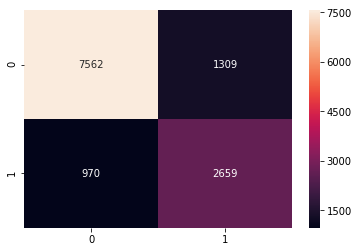

In [0]:
model_rf = RandomForestClassifier()
# , X_train=X_train_pca, X_test=X_test_pca
execute_model_stratified_kfold(model_rf)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Score = 0.81824 
Precision = 0.73582 
Recall = 0.66683 
AUC = 0.77774


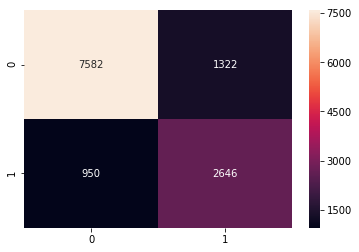

age
anemia
anxietydisorders
asthma
backproblem
chrkidneydisease
copd
coronathero
diabmelnoc
dysrhythmia
esophgealdx
headachemig
htn
hyperlipidem
mooddisorders
othergidx
othnervdx
otjointdx
otnutritdx
thyroiddsor
unclassified
n_edvisits
n_admissions
bloodua_npos
leukocytesua_npos
bloodua_count
glucoseua_count
ketonesua_count
leukocytesua_count
nitriteua_count
pregtestur_count
proteinua_count
urineculture,routine_count
cxr_count
ekg_count
headct_count
otherct_count
otherus_count
otherxr_count
meds_analgesics
meds_antiarthritics
meds_antiasthmatics
meds_antibiotics
meds_anticoagulants
meds_antihyperglycemics
meds_antiplateletdrugs
meds_cardiacdrugs
meds_cardiovascular
meds_cnsdrugs
meds_diuretics
meds_elect/caloric/h2o
meds_gastrointestinal
meds_hormones
meds_psychotherapeuticdrugs
meds_skinpreps
meds_unclassifieddrugproducts
meds_vitamins
n_surgeries
dep_name_A
dep_name_B
dep_name_C
gender_Female
gender_Male
ethnicity_Hispanic or Latino
ethnicity_Non-Hispanic
race_Black or African Americ

In [0]:
model_rf = RandomForestClassifier()
execute_model_stratified_kfold(model_rf)
print_feature_importance_rf(model_rf)

Score = 0.82616 
Precision = 0.70449 
Recall = 0.77923 
AUC = 0.81361


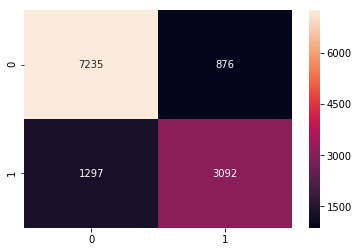

In [0]:
model = LGBMClassifier(objective='binary', boosting_type='gbdt', max_depth=20)
execute_model_stratified_kfold(model)
# ver si es festivo

Score = 0.80728 
Precision = 0.67318 
Recall = 0.76361 
AUC = 0.79560


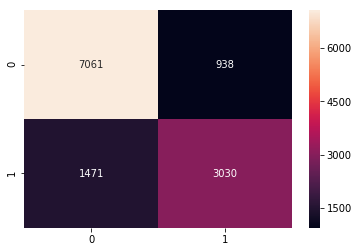

In [0]:
model_2 = LGBMClassifier(objective='binary', boosting_type='gbdt', learning_rate=0.01)
execute_model_stratified_kfold(model_2)

Score = 0.80728 
Precision = 0.67318 
Recall = 0.76361 
AUC = 0.79560


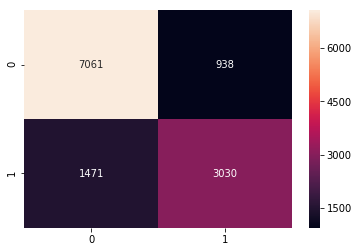

In [0]:
model_3 = LGBMClassifier(objective='binary', boosting_type='goss', learning_rate=0.01)
execute_model_stratified_kfold(model_3)

Score = 0.82744 
Precision = 0.70840 
Recall = 0.77571 
AUC = 0.81360


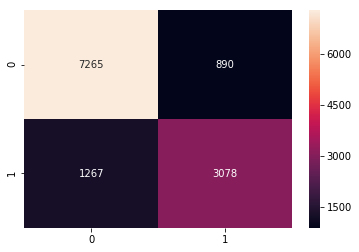

In [0]:
model_3 = LGBMClassifier(objective='binary', boosting_type='gbdt', learning_rate=0.15)
execute_model_stratified_kfold(model_3)

Score = 0.82640 
Precision = 0.70367 
Recall = 0.78276 
AUC = 0.81473


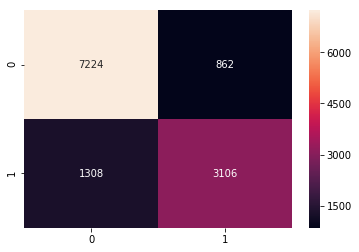

In [0]:
model_4 = LGBMClassifier(objective='binary', boosting_type='gbdt', learning_rate=0.1)
execute_model_stratified_kfold(model_4)

In [0]:
len(Y_test), sum(Y_test == 1), sum(Y_test == 0)

(2500, 820, 1680)